In [1]:
from functions import *
import pickle


In [2]:
# Load data
dataset_index = 1
data_mapped = pickle.load(open(f'cleaned_data/data_{dataset_index}.pkl', "rb"))


In [3]:
num_pedestrians = data_mapped['id'].nunique()
circumference = 2*np.pi*3 + 4 * 2

## Gradient descent

In [4]:
from scipy.interpolate import interp1d


pedestrian_ids = data_mapped['id'].unique()
num_frames = data_mapped['frame'].nunique()

# Map pedestrian ids to row indices
id_to_index = {pid: i for i, pid in enumerate(pedestrian_ids)}

real_positions = np.full((num_pedestrians, num_frames), np.nan)
for _, row in data_mapped.iterrows():
    pid_index = id_to_index[row['id']]
    frame_index = int(row['frame']) - 1
    real_positions[pid_index, frame_index] = row['position']

t_eval = np.arange(num_frames)  # Frame indices = time steps
# For testing
# t_eval = np.linspace(0, num_frames - 1, num_frames)

initial_positions = data_mapped.groupby('id').first()['position'].values

# Original time axis (frames 0 to 1820)
t_original = np.arange(real_positions.shape[1])

# Interpolate real_positions over new t_eval
interpolated_real_positions = np.array([
    interp1d(t_original, real_positions[i], kind='linear')(t_eval)
    for i in range(real_positions.shape[0])
])

In [5]:
def pedestrian_ode(t, l, c, s):
    # Default circumference
    circumference = 2*np.pi*3 + 4 * 2

    n = len(l)  # Number of pedestrians
    dl_dt = np.zeros(n)
    
    for i in range(n): 
        if i == n - 1:
            gap = l[0] - (l[i] - circumference)
        else:
            gap = l[i + 1] - l[i]
        if gap > s: 
            dl_dt[i] = c * (1 - s / gap)
        else:
            dl_dt[i] = 0  # If too close, pedestrian stops
    
    return dl_dt

In [6]:
def second_order_pedestrian_ode(t, y, c, s, tau=0.5):
    """
    Second-order pedestrian model:
    y = [x_0, ..., x_n, u_0, ..., u_n]  (positions + velocities)
    """
    # Default circumference
    circumference = 2*np.pi*3 + 4 * 2

    n = len(y) // 2  # Number of pedestrians
    x = y[:n]  # Positions
    u = y[n:]  # Velocities

    dxdt = u  # dx/dt = velocity
    dudt = np.zeros(n)  # Initialize acceleration
    
    for i in range(n): 
        next_index = (i + 1) % n  # Wrap around for circular track
        gap = (x[next_index] - x[i]) % circumference  # Circular gap
        if gap > s:
            desired_velocity = c * (1 - s / gap)  # Desired velocity based on gap
            dudt[i] = (desired_velocity - u[i]) / tau  # Acceleration towards desired velocity
        else:
            dudt[i] = -u[i] / tau  # Deceleration if too close
        
    return np.concatenate([dxdt, dudt])  # Return both position and velocity derivatives

In [18]:
def compute_predicted_positions(params, t_eval):
    # Solve ODE
    c_values = params[0]
    s_value = params[-1]
    sol = solve_ivp(
        # Use the second-order ODE function
        pedestrian_ode, 
        (0, t_eval[-1]), 
        initial_positions, 
        args=(c_values, s_value), 
        t_eval=t_eval
    )
    
    # Compute predicted positions
    predicted_positions = sol.y % circumference
    return predicted_positions

In [19]:
def compute_gradient(params, real_positions, epsilon=1e-8, t_eval=t_eval):
    grad = np.zeros_like(params)
    for i in range(len(params)):
        delta = np.zeros_like(params)
        delta[i] = epsilon
        predicted_positions = compute_predicted_positions(params - delta, t_eval)
        predicted_positions_delta = compute_predicted_positions(params + delta, t_eval)
        
        grad[i] = (loss_function(real_positions, predicted_positions_delta, t_eval)
                    - loss_function(real_positions, predicted_positions, t_eval)) / (2 * epsilon)
        
    return grad

In [20]:
mean_speed = 0.01 # m / frame
std_dev_speed = 0.002
# c_values = np.random.normal(mean_speed, std_dev_speed, num_pedestrians)  # Random walking speeds normally distributed
# c_values = np.clip(c_values, 0.001, 0.1)
c_values = 0.08
s_value = 0.04  # Safety distance

# params = np.concatenate([
#     [c_values],  # initial speeds
#     [s_value] # initial safe distance
# ])
params = [c_values, s_value]

# params = initial_guess.copy()
learning_rate = 0.0000001
learning_rate_max = 0.1

epsilon = 1e-8

num_iterations = 1000

loss_history = []

for i in range(num_iterations):
    predicted_positions = compute_predicted_positions(params, t_eval)
    loss = loss_function(interpolated_real_positions, predicted_positions, t_eval)
    grad = compute_gradient(params, interpolated_real_positions, epsilon, t_eval)
    print(f'gradient in iteration{i}: {grad}, params: {params}')
    max_grad_component = np.max(np.abs(grad))
    learning_rate = np.min([learning_rate_max, 0.00001 / max_grad_component])
    print(f'learning_rate: {learning_rate}')
    params -= learning_rate * grad
    loss_history.append(loss)

    print(f'Iteration {i+1}/{num_iterations}: Loss = {loss}')

gradient in iteration0: [143392.15690597 -22363.81960756], params: [0.08, 0.04]
learning_rate: 6.973882125615283e-11
Iteration 1/1000: Loss = 4497.971963104515
gradient in iteration1: [-722927.81742362  -46932.85322901], params: [0.07999    0.04000156]
learning_rate: 1.383263966192099e-11
Iteration 2/1000: Loss = 4505.868907648371
gradient in iteration2: [ 35059.13177833 -18082.71158552], params: [0.08       0.04000221]
learning_rate: 2.852323914701807e-10
Iteration 3/1000: Loss = 4497.9283630202235
gradient in iteration3: [-757923.02700393  -58268.28873978], params: [0.07999    0.04000737]
learning_rate: 1.3193951949883428e-11
Iteration 4/1000: Loss = 4505.561935753396
gradient in iteration4: [-15772.15539328 -17732.78313522], params: [0.08       0.04000814]
learning_rate: 5.63927270961816e-10
Iteration 5/1000: Loss = 4497.824589603423
gradient in iteration5: [4526891.26218502 -777150.64453514], params: [0.08000889 0.04001814]
learning_rate: 2.209021472093688e-12
Iteration 6/1000: Los

https://pdips.github.io/CBXpy/examples/low_level.html \
Use gradient-free method cbx to optimize loss function

## Optimize loss function by cbx

In [10]:
def objective_function(params_batch):
    losses = []
    for params in params_batch:
        if (min(params) < 0):
            losses.append(np.inf)
            continue
        predicted_positions = compute_predicted_positions(params, t_eval)
        loss = loss_function(interpolated_real_positions, predicted_positions, t_eval)
        losses.append(loss)
    return np.array(losses)

from cbx.utils import init_particles

N = 50  # Number of particles
d = 2   # Dimension of the parameter space
x_min = np.array([0, 0])  # Lower bounds for c_values and s_value
x_max = np.array([0.2, 0.2])    # Upper bounds for c_values and s_value




In [11]:
from cbx.dynamics import CBO, CBXDynamic

cbo_params = {
    'alpha': 40.0,   # alpha parameter
    'dt': 0.1,       
    'sigma': 1.,    # Noise intensity
    'lamda': 1.0,   
    'max_it': 100,  # Maximum number of iterations
    'batch_args': {
        'batch_size': 200,
        'batch_partial': False},
    'N': N,          # Number of particles
    'd': d,           # Dimension of the parameter space
    'track_args': {
        'names': [
            'energy', 
            'x', 
            'consensus', 
            'drift'
        ]
    },  # Track energy, positions, consensus, and drift
}




Iteration 100: Loss = 4260.892531433349


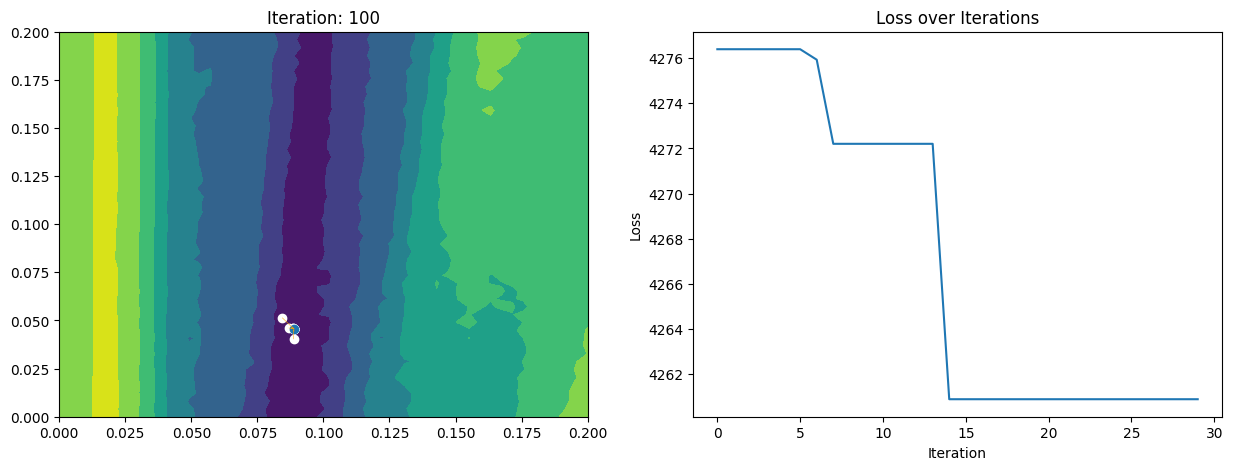

In [12]:
import matplotlib.pyplot as plt
from IPython import display

from cbx.plotting import PlotDynamic
from cbx.scheduler import effective_sample_size

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

particles = init_particles(shape=(N, d), x_min=x_min, x_max=x_max)
cbo = CBO(objective_function, x=particles, noise='isotropic', f_dim='2D', **cbo_params)

sched = effective_sample_size(maximum=1e12)
plotter = PlotDynamic(
    cbo, ax=ax[0],
    objective_args={'x_min': 0, 'x_max': 0.2},
    particle_args={'color': 'xkcd:white'},
    plot_consensus=True,
    plot_drift=True
)
plotter.init_plot()

while not cbo.terminate():
    display.clear_output(wait=True)
    cbo.step()
    sched.update(cbo)
    current_loss = cbo.history['energy'][-1][0]
    print(f'Iteration {cbo.it}: Loss = {current_loss}')

    # Update loss plot
    ax[1].clear()
    ax[1].plot([e[0] for e in cbo.history['energy'][-30:]])
    ax[1].set_title('Loss over Iterations')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Loss')

    ax[0].set_title(f'Iteration: {cbo.it}')
    # ax[0].set_xlabel('c value')
    # ax[0].set_ylabel('s value')
    plotter.update(wait=0.2)
    display.display(fig)

In [13]:
print(f'Final parameters: {cbo.best_particle}')
print(f'Final loss: {objective_function(cbo.best_particle)}')

Final parameters: [[0.08873866 0.04567424]]
Final loss: [4260.89253143]


Task:\
- Exclude ending from the dataset
- Add accelaration term to simulate the beginning behaviour
- Add current result to report and share